In [100]:
from rasterio.features import sieve
import rasterio
import os
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [120]:
num_classes = 9

In [143]:

import ast



lc_pixels = {
    0: str([255, 255, 255, 255]),
    1: str([210, 0, 0, 255]),
    2: str([253, 211, 39, 255]),
    3: str([35, 152, 0, 255]),
    4: str([8, 98, 0, 255]),
    5: str([249, 150, 39, 255]),
    6: str([141, 139, 0, 255]),
    7: str([149, 107, 196, 255]),
    8: str([77, 37, 106, 255]),
}

lc_labels_classes = {
    0: 'Other',
    1: 'Artificial surfaces and constructions',
    2: 'Cultivated areas',
    3: 'Broadleaf tree cover',
    4: 'Coniferous tree cover',
    5: 'Herbaceous vegetation',
    6: 'Moors and Heathland',
    7: 'Marshes',
    8: 'Peatbogs',
}

# to revert to an image
def create_img_from_classes(img_classes):
    img = np.zeros((img_classes.shape[0], img_classes.shape[1], 4), dtype=np.uint8)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if np.equal(img_classes[i,j], np.zeros(num_classes)).all():
                img[i,j, :] = [0, 0, 0, 255]
            else:
                img[i,j] = ast.literal_eval(lc_pixels[np.argmax(img_classes[i,j])])
    return img

def unprocess(ma):
    ma = np.array(ma, dtype=np.float32)[0]
    ma = np.moveaxis(ma, 0, -1)
    return ma

In [105]:
dataset = "train"
root_dir = os.path.join("grid_dir", dataset, "reduced_classes")
files = os.listdir(root_dir)

In [145]:
sieve_size = 5

In [150]:
def get_one_hot(num):
    c = np.zeros(num_classes)
    c[num] = 1
    return c

In [155]:
def do_sieve(root_dir, file):

    with np.load(os.path.join(root_dir, file)) as n_file:
        lc = n_file["arr_0"]
        lc_c = np.argmax(lc, 2)
        lc_s = sieve(np.array(lc_c, dtype=rasterio.uint8), size=sieve_size)
        
    return np.array([get_one_hot(i) for i in lc_s.flatten()]).reshape((256, 256, num_classes))

In [161]:
for dataset in [ "val", "test"]:
    print("dataset", dataset)
    root_dir = f"grid_dir/{dataset}/reduced_classes"
    new_dir = f"grid_dir/{dataset}/lc_sieve"
    if not os.path.exists(new_dir):
        os.mkdir(new_dir)
    files = os.listdir(root_dir)
    for idx in tqdm(range(len(files))):
        file = files[idx]
        fn = file.split(".")[0]
        
        new_classes = do_sieve(root_dir, file)
        np.savez_compressed(os.path.join(new_dir, fn + ".npz"), new_classes)

  0%|                                                                                 | 1/2881 [00:00<05:43,  8.38it/s]

dataset val


  0%|                                                                                 | 1/3153 [00:00<07:18,  7.18it/s]

dataset test


100%|██████████████████████████████████████████████████████████████████████████████| 3153/3153 [06:50<00:00,  7.67it/s]


In [98]:
with Image.open(os.path.join(root_dir, files[0])) as f:
    img = np.array(f)[:,:,:3]

Text(0.5, 1.0, 'Post Sieve')

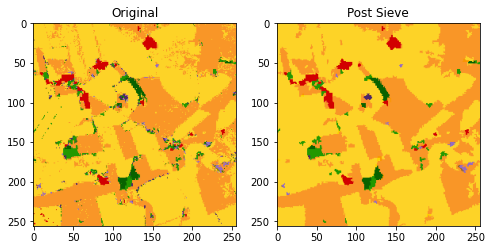

In [99]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].imshow(img)
ax[0].set_title("Original")

ax[1].imshow(im)
ax[1].set_title("Post Sieve")

In [89]:
rgb = Image.open("grid_dir/train/rgb/"+files[0])

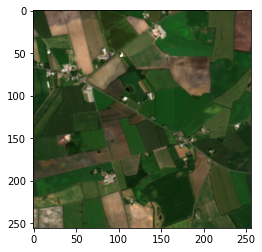

In [90]:
plt.imshow(rgb)